In [1]:
import cv2
import keras
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from keras.layers.normalization import BatchNormalization
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.models import Sequential, Model
from keras import optimizers
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
from os import listdir
import glob
from skimage import io, transform, exposure, color

def preprocess(img):
    img = transform.resize(img,(28,28))
    hsv = color.rgb2hsv(img)
    hsv[:,:,2] = exposure.equalize_hist(hsv[:,:,2])
    return color.hsv2rgb(hsv)

def read_img(path):
    images = []
    for img_path in glob.glob(path+"/*.ppm"):
        img = io.imread(img_path)
        img = preprocess(img)
        images.append(img)
    return images

def load_data(path):
    img_list = list()
    labels = list()
    for f in listdir(path):
        images = read_img(path+'/'+f)
        mul = len(images)
        img_list = img_list+images
        labels = labels + [int(f)]*mul
    return np.array(img_list,dtype = 'float32'),np.array(labels,dtype = 'float32')
    

In [4]:
train_path = "/media/nishanth/E/bigdatathings/ML-DL/traffic-signs/GTSRB/Final_Training/train"
train_x, train_y =  load_data(train_path)


/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [5]:
from keras.utils import to_categorical
train_y = to_categorical(train_y)

In [6]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(train_x,train_y,test_size=0.2,random_state=42)
print "training data",x_train.shape
print "training labels",y_train.shape
print "validation data",x_val.shape
print "validation labels",y_val.shape

training data (27804, 28, 28, 3)
training labels (27804, 43)
validation data (6952, 28, 28, 3)
validation labels (6952, 43)


class :  2


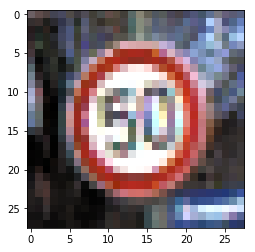

In [8]:
img = x_val[200]
plt.imshow(img)
print "class : ",np.argmax(y_val[200])

In [7]:
def create_model():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same',
                     input_shape=(28, 28, 3),
                     activation='relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
   
    
    

    model.add(Conv2D(64, (3, 3), padding='same',
                     activation='relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
   

    model.add(Conv2D(128, (3, 3), padding='same',
                     activation='relu'))
    model.add(Conv2D(128, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(BatchNormalization())
    
    

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(43, activation='softmax'))
    return model


In [8]:
model = create_model()

In [9]:
sgd = SGD(lr=1e-2, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
          optimizer=sgd,
          metrics=['accuracy'])

In [10]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-5)
checkpoint = ModelCheckpoint('traffic_sign_model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [128]:
model.fit(x_train, y_train, epochs=25, validation_data=(x_val,y_val), callbacks=[reduce_lr, checkpoint])

Train on 27804 samples, validate on 6952 samples
Epoch 1/25
27804/27804 [==============================] - 170s 6ms/step - loss: 0.7165 - acc: 0.8072 - val_loss: 0.3059 - val_acc: 0.9052
Epoch 2/25
27804/27804 [==============================] - 187s 7ms/step - loss: 0.1185 - acc: 0.9649 - val_loss: 0.1335 - val_acc: 0.9590
Epoch 3/25
27804/27804 [==============================] - 194s 7ms/step - loss: 0.0607 - acc: 0.9825 - val_loss: 0.1395 - val_acc: 0.9563
Epoch 4/25
27804/27804 [==============================] - 197s 7ms/step - loss: 0.0435 - acc: 0.9869 - val_loss: 0.0443 - val_acc: 0.9876
Epoch 5/25
27804/27804 [==============================] - 195s 7ms/step - loss: 0.0333 - acc: 0.9900 - val_loss: 0.0535 - val_acc: 0.9842
Epoch 6/25
27804/27804 [==============================] - 200s 7ms/step - loss: 0.0226 - acc: 0.9929 - val_loss: 0.0689 - val_acc: 0.9794
Epoch 7/25
27804/27804 [==============================] - 202s 7ms/step - loss: 0.0189 - acc: 0.9946 - val_loss: 0.0653 - v

In [14]:
import pandas as pd
test_data = pd.read_csv("/media/nishanth/E/bigdatathings/ML-DL/traffic-signs/GTSRB/Final_Test/GT-final_test.csv",sep=";")

In [15]:
x_test = np.empty((12630,28,28,3),dtype=np.float32)
y_test = []
path = "/media/nishanth/E/bigdatathings/ML-DL/traffic-signs/GTSRB/Final_Test/Images"
for idx,image_path in enumerate(glob.glob(path+"/*.ppm")):
    img = io.imread(image_path)
    img = preprocess(img)
    label = int(test_data.loc[test_data['Filename']==image_path[-9:]]['ClassId'])
    x_test[idx] = img
    y_test.append(label)

y_test = to_categorical(np.array(y_test,dtype = 'float32'))


Data Augmentation improves accuracy
-----------------------------------------------

In [13]:
datagen = ImageDataGenerator(featurewise_center=False, 
                            featurewise_std_normalization=False, 
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.2,
                            shear_range=0.1,
                            rotation_range=10.,)

datagen.fit(x_train)


In [14]:
model.fit_generator(datagen.flow(x_train, y_train, batch_size=32), epochs=25, validation_data=(x_val,y_val), callbacks=[reduce_lr])

Epoch 1/25
869/869 [==============================] - 182s 210ms/step - loss: 1.4952 - acc: 0.5647 - val_loss: 0.5371 - val_acc: 0.8284
Epoch 2/25
869/869 [==============================] - 183s 210ms/step - loss: 0.3835 - acc: 0.8785 - val_loss: 0.1103 - val_acc: 0.9679
Epoch 3/25
869/869 [==============================] - 183s 210ms/step - loss: 0.2283 - acc: 0.9270 - val_loss: 0.1206 - val_acc: 0.9619
Epoch 4/25
869/869 [==============================] - 186s 214ms/step - loss: 0.1768 - acc: 0.9428 - val_loss: 0.0668 - val_acc: 0.9796
Epoch 5/25
869/869 [==============================] - 195s 224ms/step - loss: 0.1361 - acc: 0.9565 - val_loss: 0.0633 - val_acc: 0.9796
Epoch 6/25
869/869 [==============================] - 189s 218ms/step - loss: 0.1159 - acc: 0.9619 - val_loss: 0.0432 - val_acc: 0.9866
Epoch 7/25
869/869 [==============================] - 211s 243ms/step - loss: 0.1020 - acc: 0.9679 - val_loss: 0.0378 - val_acc: 0.9869
Epoch 8/25
869/869 [============================

In [19]:
score = model.evaluate(x_test,y_test)
print "test_set accuracy :",score[1]*100

12630/12630 [==============================] - 28s 2ms/step
test_set accuracy : 98.4323040352
